# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 14, 2019

## Basic Segmentation and Discrete Binary Structures
### Part 2

# A Machine Learning Approach to Image Processing

Segmentation and all the steps leading up to it are really a specialized type of learning problem. Let's look at an important problem for self-driving cars. 

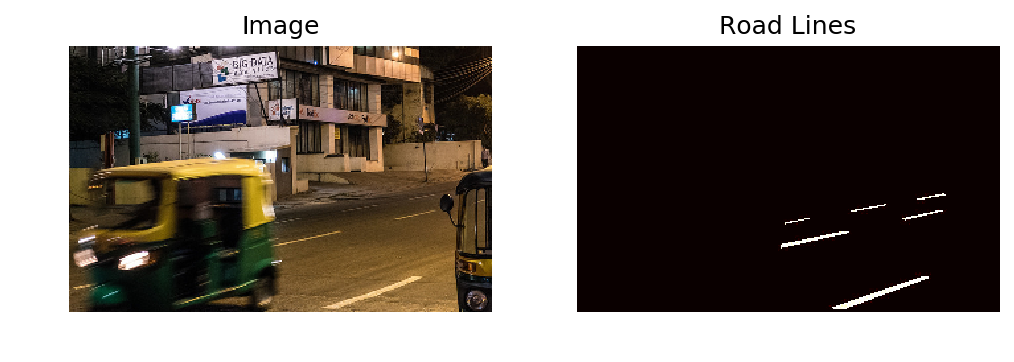

In [1]:
%matplotlib inline
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
road_rgb = imread("../common/data/road_image.jpg")[::2, ::2]
road_seg = rgb2gray(imread("../common/data/road_image_seg_bw.jpg"))[::2, ::2]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4), dpi = 150)
ax1.imshow(road_rgb)
ax2.imshow(road_seg, cmap = 'hot')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Image')
ax2.set_title('Road Lines');

We want to identify which class each pixel belongs to.
What does identify mean?
- Classify the pixels in the street lines as _Foreground_
- Classify the pixels outside of the street lines as _Background_

# How do we quantify this?

- __True Positive__ values in the street lines that are classified as _Foreground_
- __True Negative__ values outside the street lines that are classified as _Background_
- __False Positive__ values outside the street lines that are classified as _Foreground_
- __False Negative__ values in the street lines that are classified as _Background_

We can then apply a threshold to the image to determine the number of points in each category


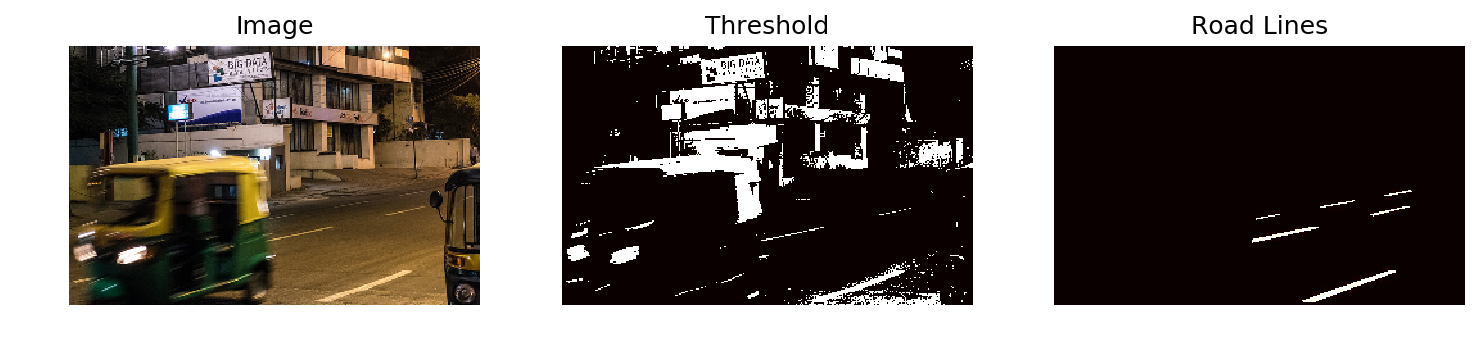

In [2]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), dpi = 150)
ax1.imshow(road_rgb)
thresh_img = rgb2gray(road_rgb)>0.5
ax2.imshow(thresh_img, cmap = 'hot')
ax3.imshow(road_seg, cmap = 'hot')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('Image')
ax2.set_title('Threshold')
ax3.set_title('Road Lines');

{'True Negative': 53706, 'False Positive': 9857, 'False Negative': 125, 'True Positive': 173}


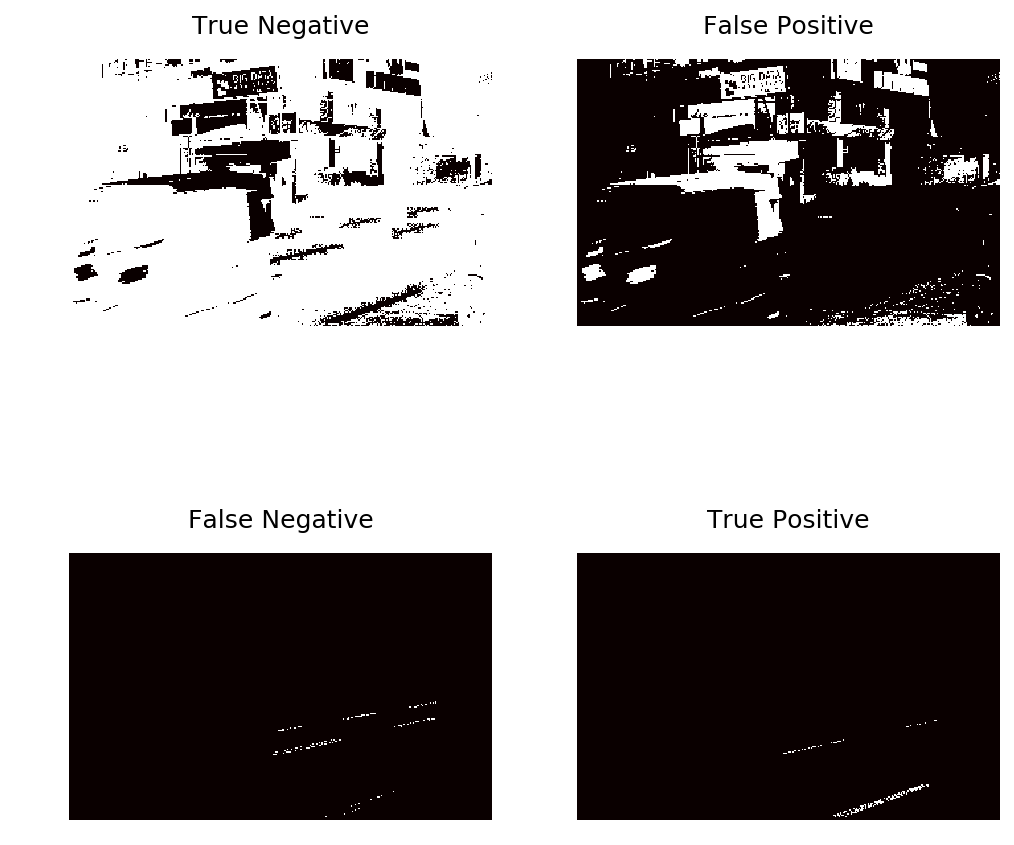

In [3]:
def tp_func(real_img_idx, pred_img_idx):
    if real_img_idx==1 and pred_img_idx==1:
        return 'True Positive'
    if real_img_idx==0 and pred_img_idx==0:
        return 'True Negative'
    if real_img_idx==0 and pred_img_idx==1:
        return 'False Positive'
    if real_img_idx==1 and pred_img_idx==0:
        return 'False Negative'
out_results = {}
fig, m_ax = plt.subplots(2, 2, figsize = (8, 8), dpi = 150)
for real_img_idx, n_ax in zip([0, 1], m_ax):
    for pred_img_idx, c_ax in zip([0, 1], n_ax):
        match_img = (thresh_img==pred_img_idx) & (road_seg == real_img_idx)
        tp_title = tp_func(real_img_idx, pred_img_idx)
        c_ax.matshow(match_img, cmap = 'hot')
        out_results[tp_title] = np.sum(match_img)
        c_ax.set_title(tp_title)
        c_ax.axis('off')
print(out_results)

# Apply Precision and Recall


- __Recall__ (sensitivity)= $TP/(TP+FN)$
- __Precision__ = $TP/(TP+FP)$

In [4]:
print('Recall: %2.2f' % (out_results['True Positive'] / (out_results['True Positive']+out_results['False Negative'])))
print('Precision: %2.2f' % (out_results['True Positive'] / (out_results['True Positive']+out_results['False Positive'])))

Recall: 0.58
Precision: 0.02


### ROC Curve 
Reciever Operating Characteristic (first developed for WW2 soldiers detecting objects in battlefields using radar). The ideal is the top-right (identify everything and miss nothing). As we saw before, for a single threshold value 0.5, we were able to compute a single recall and precision. If we want to make an ROC curve we take a number of threshold values

In [5]:
import pandas as pd
out_vals = []
for thresh_val in np.linspace(0.1, 0.9):
    thresh_img = rgb2gray(road_rgb)>thresh_val
    for real_img_idx in [0, 1]:
        for pred_img_idx in [0, 1]:
            match_img = (thresh_img==pred_img_idx) & (road_seg == real_img_idx)
            tp_title = tp_func(real_img_idx, pred_img_idx)
            out_results[tp_title] = np.sum(match_img)
    out_vals += [
        dict(
            Threshold = thresh_val,
            Recall = out_results['True Positive'] / (out_results['True Positive']+out_results['False Negative']),
            Precision = (out_results['True Positive'] / (out_results['True Positive']+out_results['False Positive']))
        )]

roc_df = pd.DataFrame(out_vals)
roc_df.head(3)

,Precision,Recall,Threshold
0,0.006374,0.996644,0.100000
1,0.006653,0.996644,0.116327
2,0.006899,0.989933,0.132653


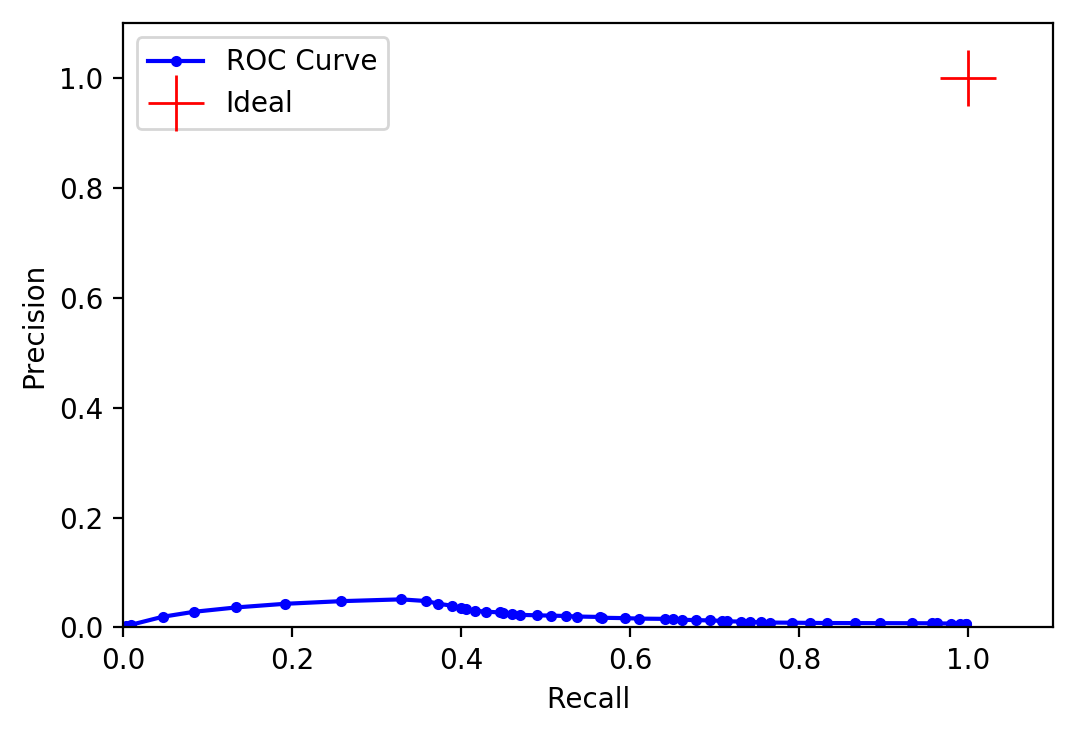

In [6]:
fig, ax1 = plt.subplots(1, 1, dpi = 200)
ax1.plot(roc_df['Recall'], roc_df['Precision'], 'b.-', label = 'ROC Curve')
ax1.plot(1.0, 1.0, 'r+', markersize = 20, label = 'Ideal')
ax1.set_xlim(0, 1.1)
ax1.set_ylim(0, 1.1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend(loc = 2);

# Making ROC Curves Easier
ROC curves are a very common tool for analyzing the performance of binary classification systems and there are a large number of tools which can automatically make them. Here we show how it is done with scikit-image. 

Another way of showing the ROC curve (more common for machine learning rather than medical diagnosis) is using the True positive rate and False positive rate

- __True Positive Rate__ (recall)= $TP/(TP+FN)$
- __False Positive Rate__ = $FP/(FP+TN)$

These show very similar information with the major difference being the goal is to be in the upper left-hand corner. Additionally random guesses can be shown as the slope 1 line. Therefore for a system to be useful it must lie above the random line.

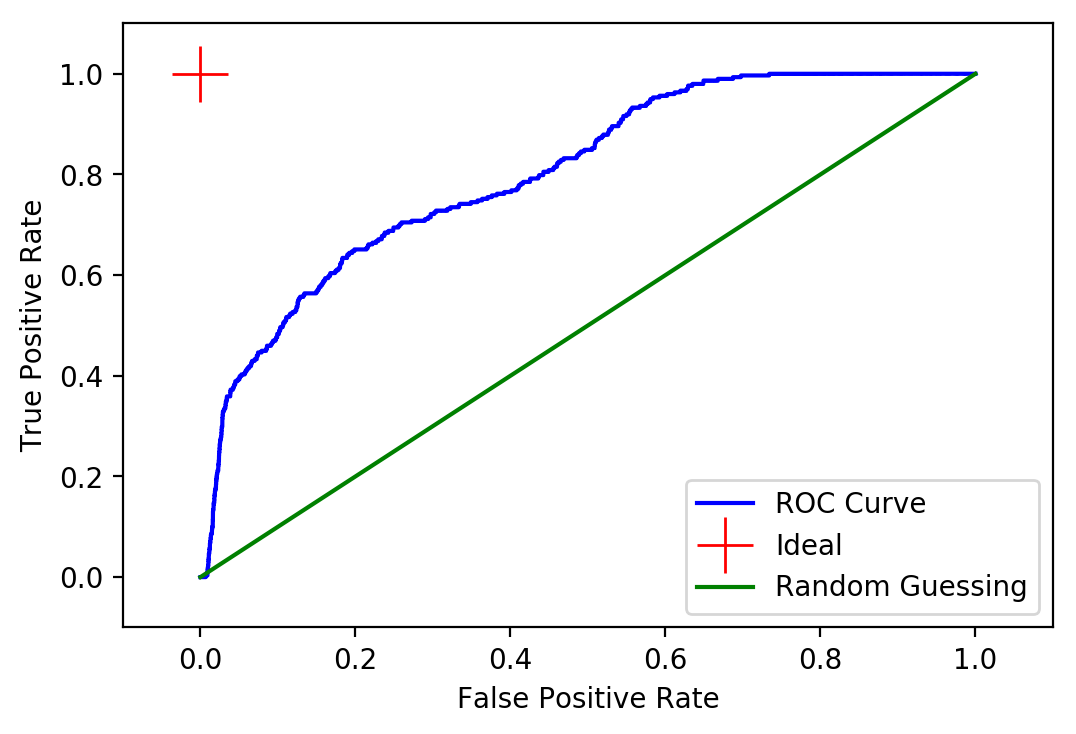

In [7]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(road_seg.ravel().astype(int) , 
                                 rgb2gray(road_rgb).ravel())

fig, ax1 = plt.subplots(1, 1, dpi = 200)
ax1.plot(fpr, tpr, 'b.-', markersize = 0.01,  label = 'ROC Curve')
ax1.plot(0.0, 1.0, 'r+', markersize = 20, label = 'Ideal')
ax1.plot([0, 1], [0,1], 'g-', label = 'Random Guessing')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc = 0);

/Users/kevinmader/miniconda3/envs/qbi2019/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


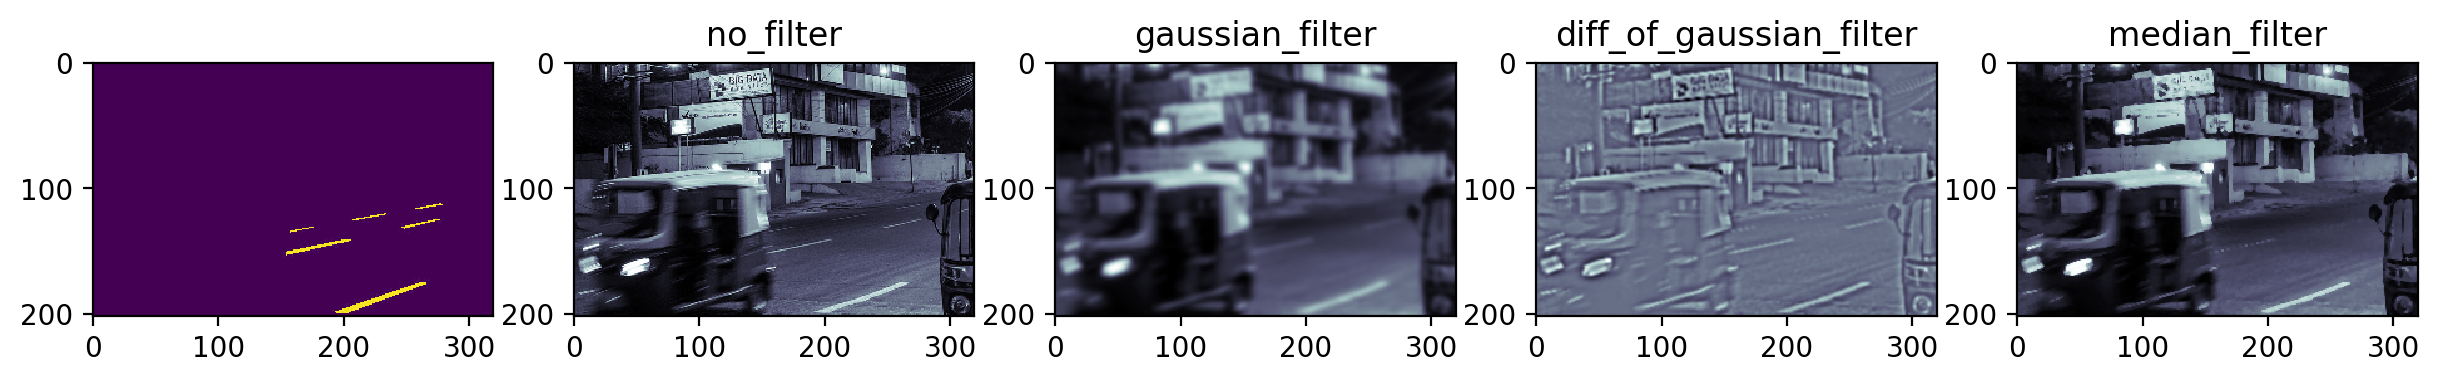

In [8]:
from skimage.filters import gaussian, median

def no_filter(x):
    return x

def gaussian_filter(x):
    return gaussian(x, sigma = 2)

def diff_of_gaussian_filter(x):
    return gaussian(x, sigma = 1)-gaussian(x, sigma = 3)

def median_filter(x):
    return median(x, np.ones((3,3)))

fig, m_axs = plt.subplots(1, 5, figsize = (15, 3), dpi = 200)
m_axs[0].imshow(road_seg)
for c_filt, c_ax in zip([no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter], m_axs[1:]):
    c_ax.imshow(c_filt(rgb2gray(road_rgb)), cmap = 'bone')
    c_ax.set_title(c_filt.__name__)

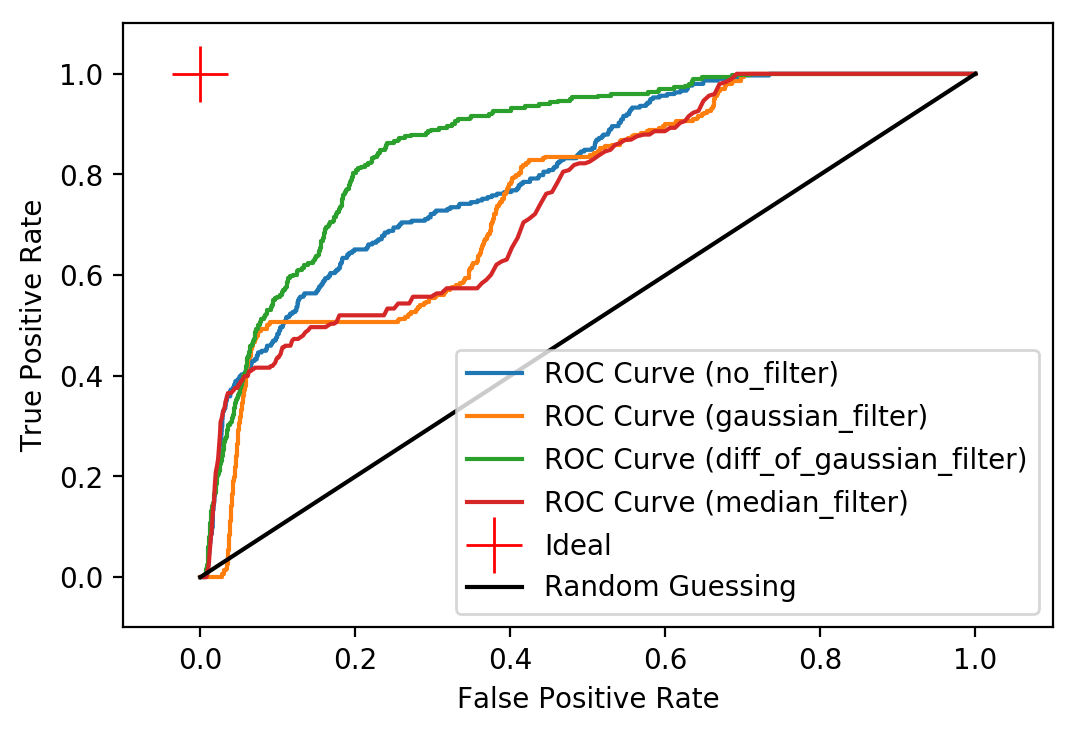

In [9]:
fig, ax1 = plt.subplots(1, 1, dpi = 200)
for c_filt in [no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter]:
    fpr, tpr, thresholds = roc_curve(road_seg.ravel().astype(int) , 
                                     c_filt(rgb2gray(road_rgb)).ravel())
    ax1.plot(fpr, tpr, '-', markersize = 0.01,  label = 'ROC Curve ({})'.format(c_filt.__name__))

ax1.plot(0.0, 1.0, 'r+', markersize = 20, label = 'Ideal')
ax1.plot([0, 1], [0,1], 'k-', label = 'Random Guessing')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc = 0);

We can then use this ROC curve to compare different filters (or even entire workflows), if the area is higher the approach is better.

Different approaches can be compared by area under the curve

In [10]:
from sklearn.metrics import roc_auc_score
for c_filt in [no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter]:
    print('%s - %2.2f' % (c_filt.__name__, roc_auc_score(road_seg.ravel().astype(int) , 
                                     c_filt(rgb2gray(road_rgb)).ravel())))


no_filter - 0.80
gaussian_filter - 0.75
diff_of_gaussian_filter - 0.87
median_filter - 0.75


/Users/kevinmader/miniconda3/envs/qbi2019/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Evaluating Models

- https://github.com/jvns/talks/blob/master/pydatanyc2014/slides.md
- http://mathbabe.org/2012/03/06/the-value-added-teacher-model-sucks/

# Multiple Phases: Segmenting Shale

- Shale provided from Kanitpanyacharoen, W. (2012). Synchrotron X-ray Applications Toward an Understanding of Elastic Anisotropy.

- Here we have a shale sample measured with X-ray tomography with three different phases inside (clay, rock, and air).
- The model is that because the chemical composition and density of each phase is different they will absorb different amounts of x-rays and appear as different brightnesses in the image

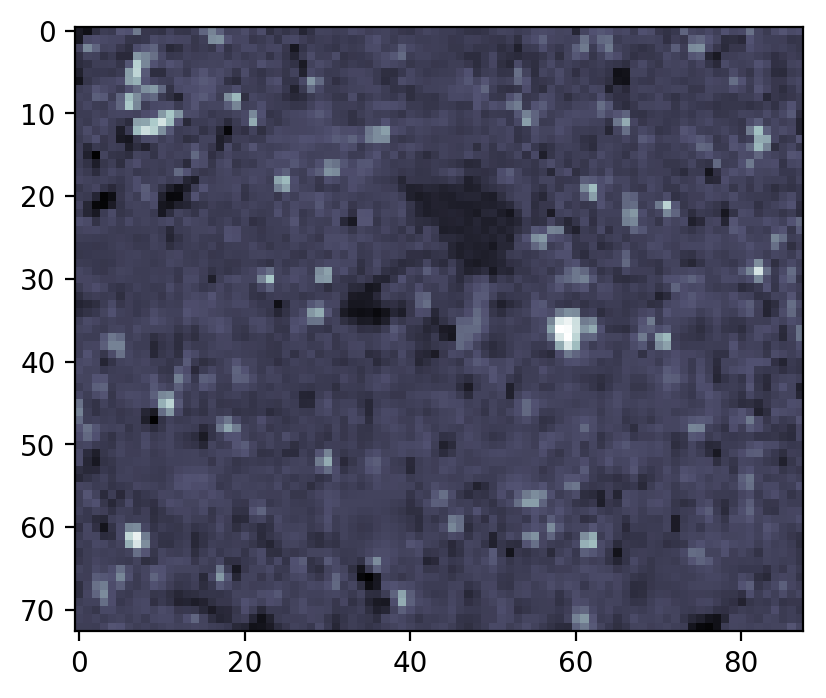

In [11]:
%matplotlib inline
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
shale_img = imread("ext-figures/ShaleSample.jpg")/255.0
fig, ax1 = plt.subplots(1, 1, dpi = 200)
ax1.imshow(shale_img, cmap = 'bone')

Ideally we would derive 3 values for the thresholds based on a model for the composition of each phase and how much it absorbs, but that is not always possible or practical.
- While there are 3 phases clearly visible in the image, the histogram is less telling (even after being re-scaled).

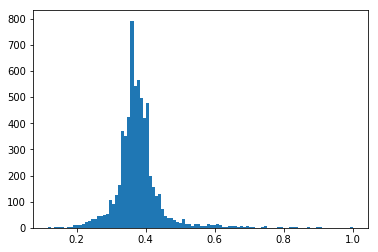

In [12]:
plt.hist(shale_img.ravel(), 100);

# Multiple Segmentations

For this exercise we choose arbitrarily 3 ranges for the different phases and perform visual inspection

The relation can explicitly be written out as
$$ I(x) = 
\begin{cases}
\text{Void}, & 0 \leq x \leq 0.3  \\
\text{Clay}, & 0.3 < x \leq 0.5 \\
\text{Rock}, & 0.5 < x
\end{cases}$$

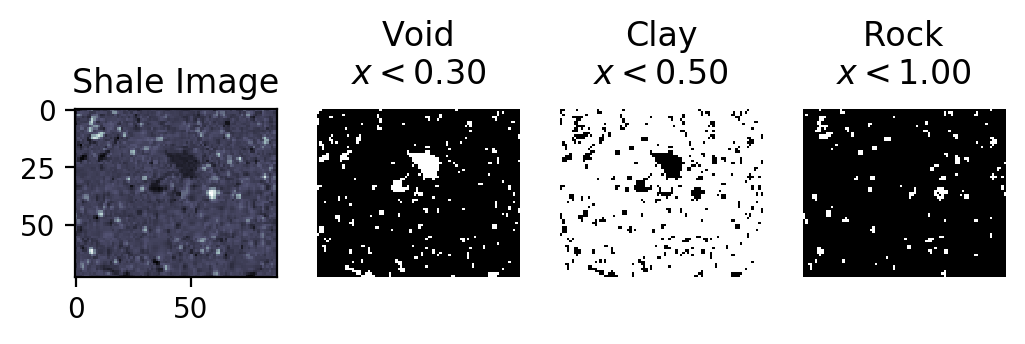

In [13]:
fig, m_axs = plt.subplots(1, 4, dpi = 200, figsize = (6, 3))
m_axs[0].imshow(shale_img, cmap = 'bone')
m_axs[0].set_title('Shale Image')
used_vox = np.zeros_like(shale_img).astype(np.uint8)
for c_ax, c_max, c_title in zip(m_axs[1:], [0.3, 0.5, 1.0], ['Void', 'Clay', 'Rock']):
    c_slice = (shale_img<c_max)-used_vox
    c_ax.matshow(c_slice, cmap = 'bone')
    used_vox += c_slice
    c_ax.axis('off')
    c_ax.set_title('%s\n$x<%2.2f$' % (c_title, c_max))

# Implementation

The implementations of basic thresholds and segmentations is very easy since it is a unary operation of a single image
$$ f(I(\vec{x})) $$
In mathematical terms this is called a map and since it does not require information from neighboring voxels or images it can be calculated for each point independently (_parallel_). Filters on the other hand almost always depend on neighboring voxels and thus the calculations are not as easy to seperate. 

# Implementation Code 
### Matlab
The simplist is a single threshold in Matlab: 
```matlab
thresh_img = gray_img > thresh
```

A more complicated threshold: 
```
thresh_img = (gray_img > thresh_a) & (gray_img > thresh_b)
```

### Python (numpy)
```python
thresh_img = gray_img > thresh
```

### Python
```python
thresh_img = map(lambda gray_val: gray_val>thresh,
                gray_img)
```

***

### Java
```java
boolean[] thresh_img = new boolean[x_size*y_size*z_size];
for(int x=x_min;x<x_max;x++)
  for(int y=y_min;y<y_max;y++)
    for(int z=z_min;z<z_max;z++) {
      int offset=(z*y_size+y)*x_size+x;
      thresh_img[offset]=gray_img[offset]>thresh;
    }
```
  
### In C/C++

```c
bool* thresh_img = malloc(x_size*y_size*z_size * sizeof (bool));

for(int x=x_min;x<x_max;x++)
  for(int y=y_min;y<y_max;y++)
    for(int z=z_min;z<z_max;z++) {
      int offset=(z*y_size+y)*x_size+x;
      thresh_img[offset]=gray_img[offset]>thresh;
    }
```

# Pitfalls with Segmentation

### Partial Volume Effect
- The [partial volume effect](http://bit.ly/1mW7kdP) is the name for the effect of discretization on the image into pixels or voxels.
- Surfaces are complicated, voxels are simple boxes which make poor representations
- Many voxels are only partially filled, but only the voxels on the surface
- Removing the first layer alleviates issue

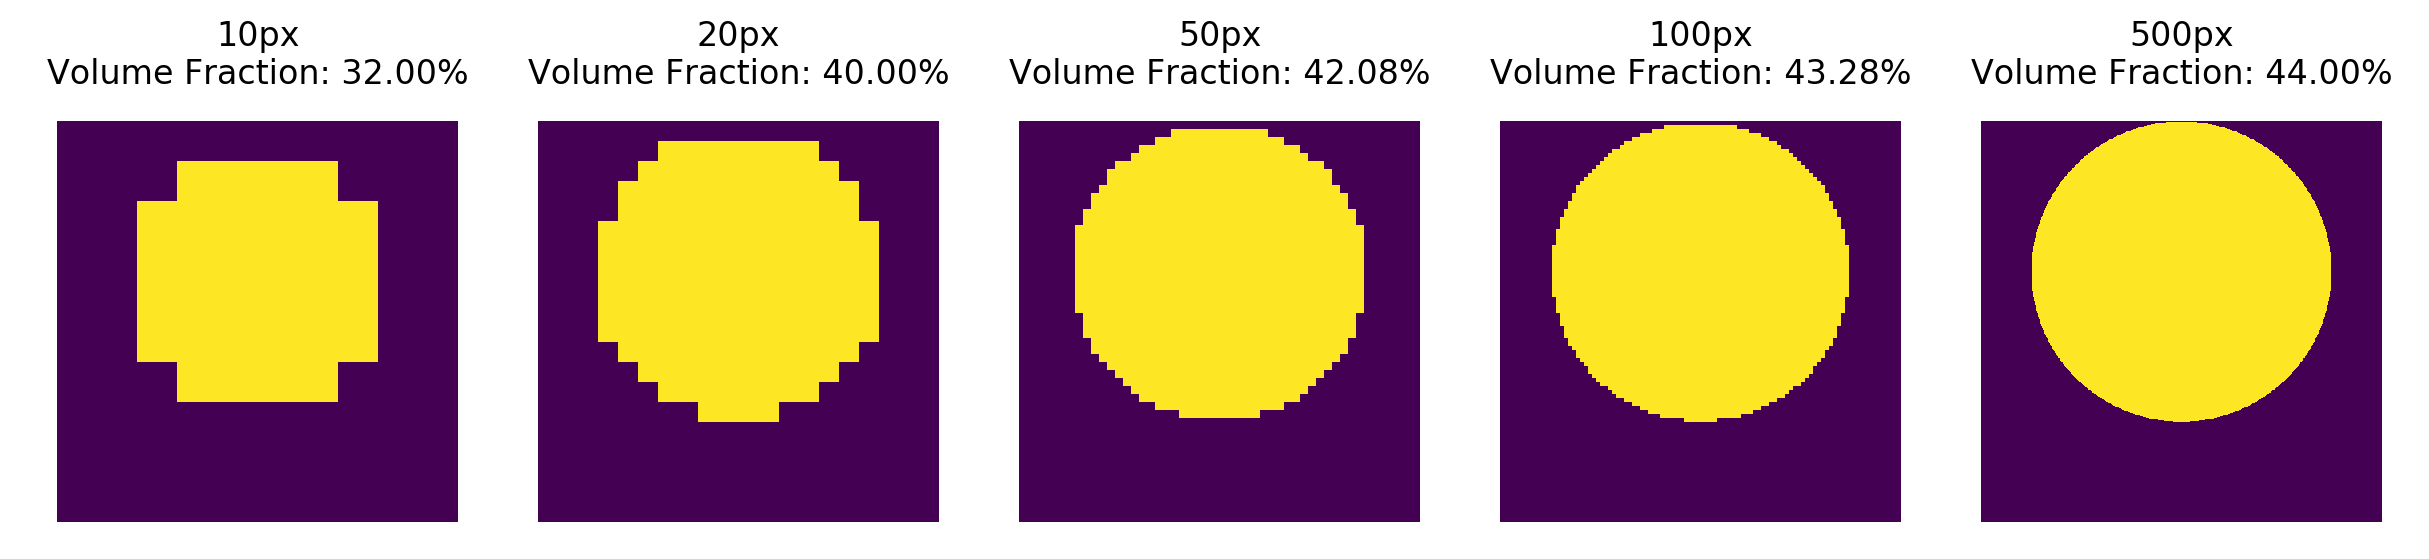

In [14]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
step_list = [10, 20, 50, 100, 500]
fig, m_axs = plt.subplots(1,len(step_list), figsize = (15, 5), dpi = 200)
for c_ax, steps in zip(m_axs, step_list):
    x_lin = np.linspace(-1, 1, steps)
    xy_area = np.square(np.diff(x_lin)[0])
    xx, yy = np.meshgrid(x_lin, x_lin)
    test_img = (np.square(xx)+np.square(yy+0.25))<np.square(0.75)
    c_ax.matshow(test_img)
    c_ax.set_title('%dpx\nVolume Fraction: %2.2f%%' % (steps, 100*np.sum(test_img)/np.prod(test_img.shape)))
    c_ax.axis('off')

# Rescaling
We see the same effect when we rescale images from 500x500 down to 15x15 that the apparent volume fraction changes 

/Users/kevinmader/miniconda3/envs/qbi2019/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


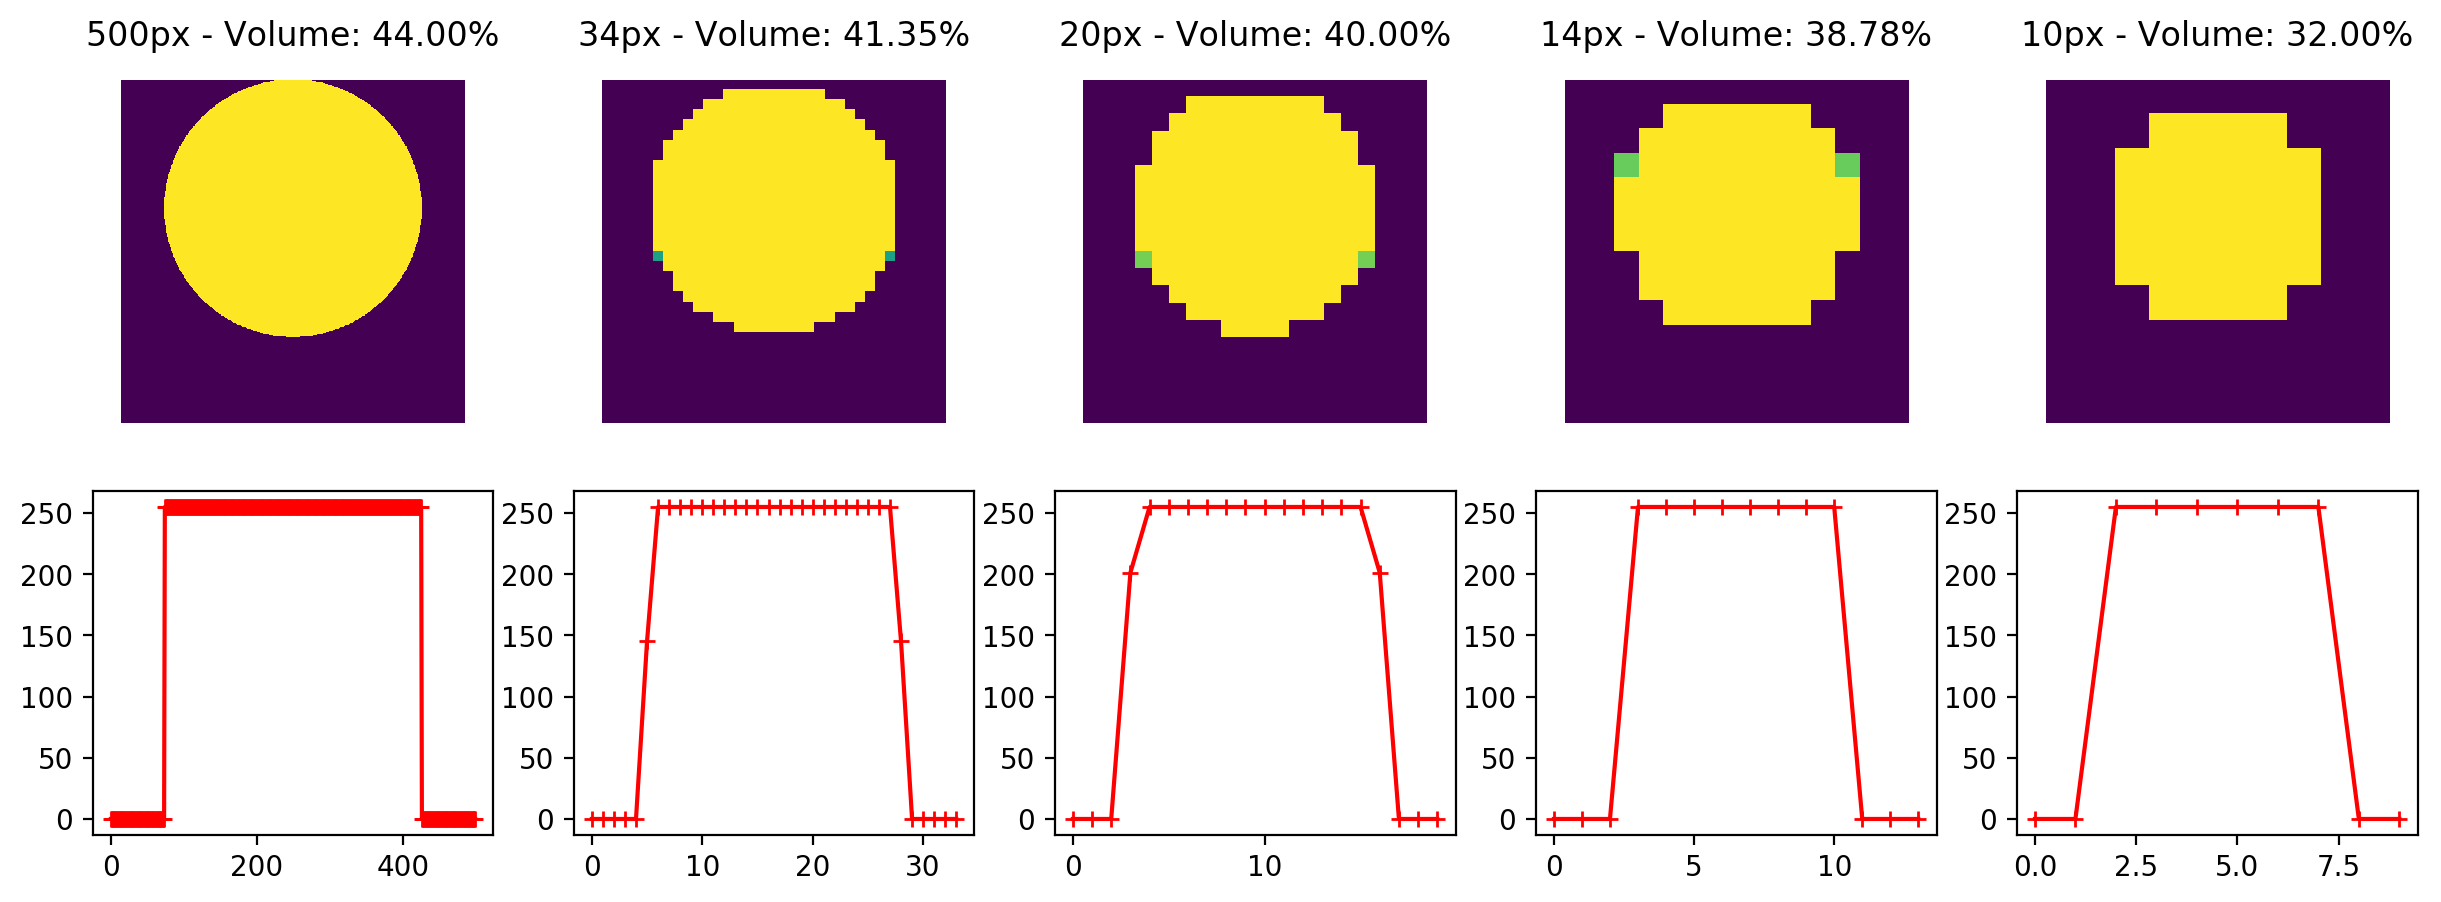

In [15]:
zoom_level = [1, 0.067, 0.039, 0.029, 0.02]
fig, m_axs = plt.subplots(2, len(zoom_level), figsize = (15, 5), dpi = 200)
for (c_ax, ax2), c_zoom in zip(m_axs.T, zoom_level):
    c_img = zoom(255.0*test_img, c_zoom, order = 1)
    c_ax.matshow(c_img)
    c_ax.set_title('%dpx - Volume: %2.2f%%' % (c_img.shape[0], 100*np.sum(c_img>0.5)/np.prod(c_img.shape)))
    c_ax.axis('off')
    ax2.plot(c_img[c_img.shape[0]//2], 'r+-')

# [Morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html)
We can now utilize information from neighborhood voxels to improve the results. These steps are called morphological operations. We return to the original image of a cross

Like filtering the assumption behind morphological operations are
- nearby voxels in __real__ images are related / strongly correlated with one another 
- noise and imaging artifacts are less spatially correlated. 

Therefore these imaging problems can be alleviated by adjusting the balance between local and neighborhood values.

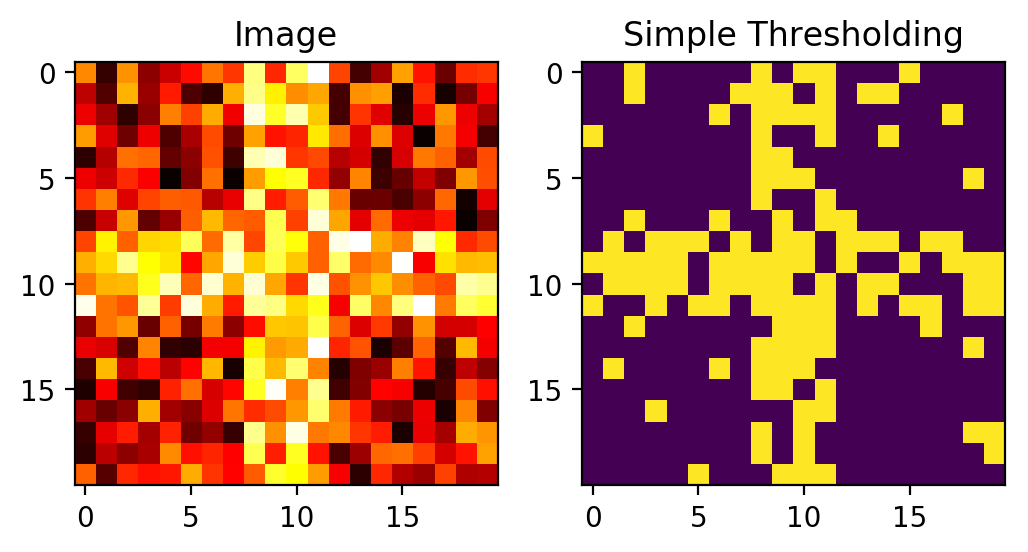

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

nx = 20
ny = 20
xx, yy = np.meshgrid(np.linspace(-10, 10, nx), 
                      np.linspace(-10, 10, ny))
np.random.seed(2018)
cross_im = 1.1*((np.abs(xx)<2)+(np.abs(yy)<2))+np.random.uniform(-1.0, 1.0, size = xx.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 3.5), dpi = 200)
ax1.imshow(cross_im, cmap = 'hot')
ax1.set_title('Image')
ax2.imshow(cross_im>0.8)
ax2.set_title('Simple Thresholding');

# Fundamentals: Neighborhood
A neighborhood consists of the pixels or voxels which are of sufficient proximity to a given point. There are a number of possible definitions which largely affect the result when it is invoked.   
- A large neighborhood performs operations over larger areas / volumes
 - Computationally intensive
 - Can _smooth_ out features
- A small neighborhood performs operations over small areas / volumes
 - Computationally cheaper
 - Struggles with large noise / filling large holes

The neighborhood is important for a large number of image and other (communication, mapping, networking) processing operations:
- filtering
- morphological operations
- component labeling
- distance maps
- image correlation based tracking methods

It is often called structuring element (or ```selem``` for sort / code), but has exactly the same meaning

# Fundamentals: Neighbors in 2D
For standard image operations there are two definitions of neighborhood. The 4 and 8 adjacent neighbors shown below. Given the blue pixel in the center the red are the 4-adjacent and the red and green make up the 8 adjacent. We expand beyond this to disk, cross, vertical and horizontal lines

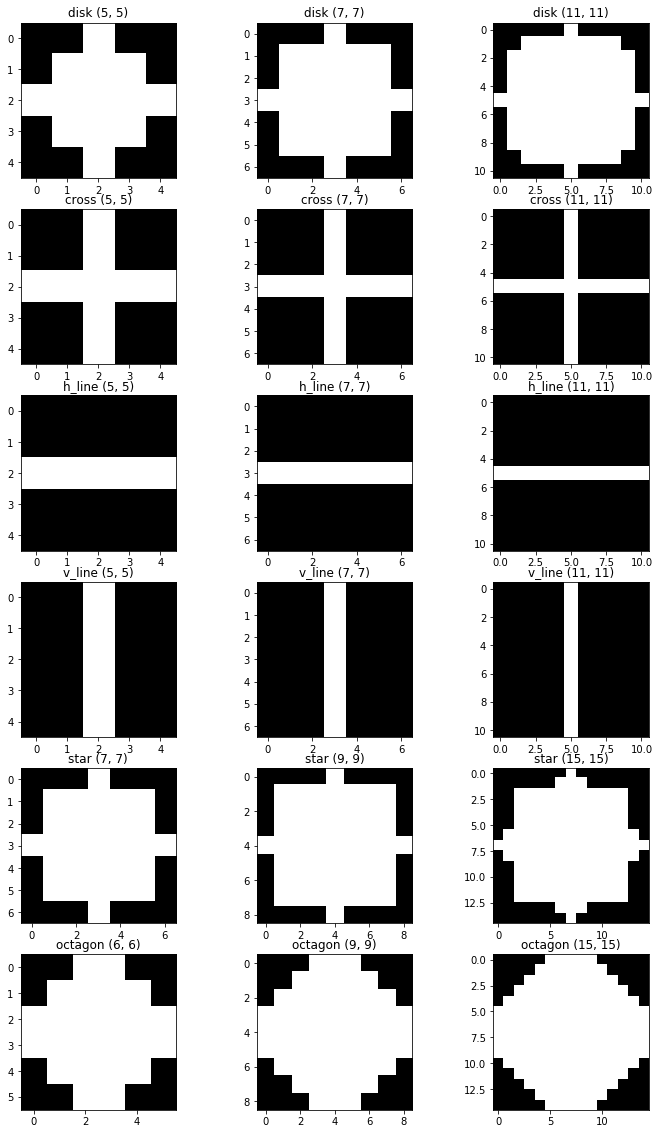

In [17]:
from skimage.morphology import disk, octagon as oct_func, star
def h_line(n):
    return np.pad(np.ones((1, 2*n+1)), [[n, n],[0,0]], mode = 'constant', constant_values = 0).astype(int)
def v_line(n):
    return h_line(n).T
def cross(n):
    return ((h_line(n)+v_line(n))>0).astype(int)
def octagon(n):
    return oct_func(n, n)

neighbor_functions = [disk, cross, h_line, v_line, star, octagon]
sizes = [2, 3, 5]
fig, m_axs = plt.subplots(len(neighbor_functions), len(sizes), figsize = (12, 20))
for c_func, c_axs in zip(neighbor_functions, m_axs):
    for c_dim, c_ax in zip(sizes, c_axs):
        c_ax.imshow(c_func(c_dim), cmap = 'bone', interpolation='none')
        c_ax.set_title('{} {}'.format(c_func.__name__, c_func(c_dim).shape))

# Erosion and Dilation

### Erosion
If any of the voxels in the neighborhood are 0/false than the voxel will be set to 0

- Has the effect of peeling the surface layer off of an object

***

### Dilation

If any of the voxels in the neigbhorhood are 1/true then the voxel will be set to 1
- Has the effect of adding a layer onto an object (dunking an strawberry in chocolate, adding a coat of paint to a car)

# Applied Erosion and Dilation

### Dilation
We can use dilation to expand objects, for example a too-low threshold value leading to disconnected components

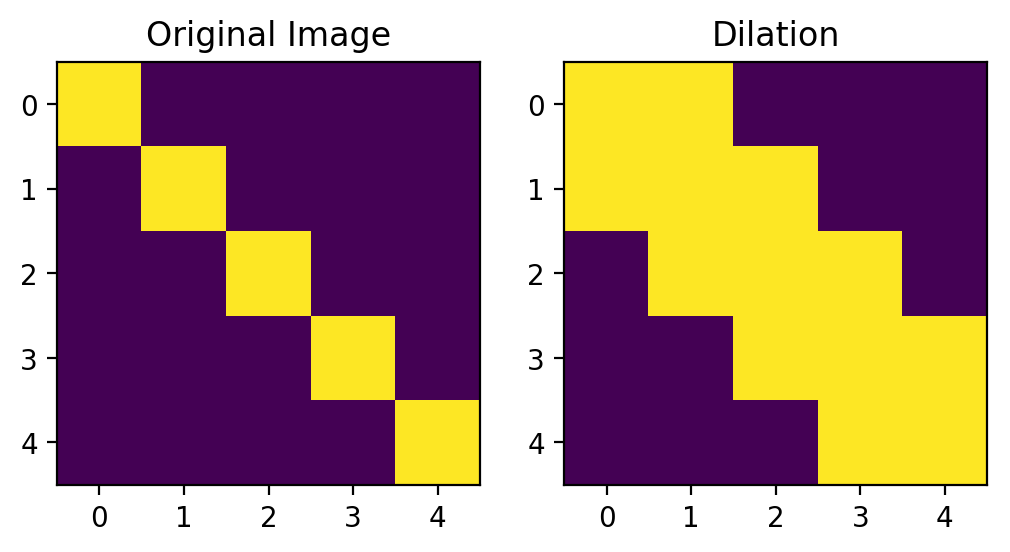

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import binary_dilation, binary_erosion, disk
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 3.5), dpi = 200)
simple_img = np.eye(5)
ax1.imshow(simple_img)
ax1.set_title('Original Image')
dil_image = binary_dilation(simple_img, disk(1))
ax2.imshow(dil_image)
ax2.set_title('Dilation');

# Erosion
Erosion performs the opposite task reducing the size

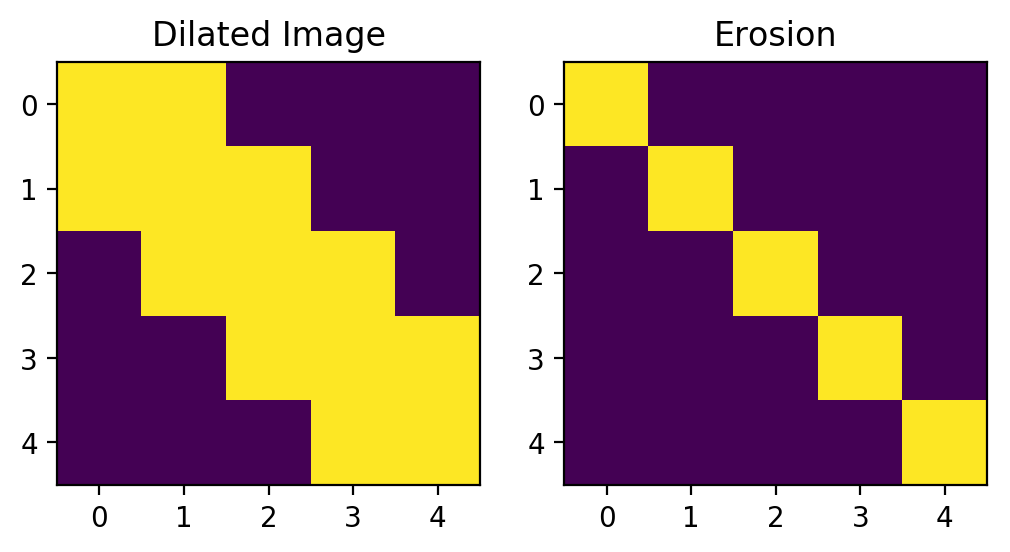

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 3.5), dpi = 200)
ax1.imshow(dil_image)
ax1.set_title('Dilated Image')
ax2.imshow(binary_erosion(dil_image, disk(1)))
ax2.set_title('Erosion');

# Opening and Closing

### Opening

An erosion followed by a dilation operation

- Peels a layer off and adds a layer on
- Very small objects and connections are deleted in the erosion and do not return the image is thus __open__ed
- A cube larger than several voxels will have the exact same volume after (conservative)

***

### Closing

A dilation followed by an erosion operation

- Adds a layer and then peels a layer off
- Objects that are very close are connected when the layer is added and they stay connected when the layer is removed thus the image is __close__d
- A cube larger than one voxel will have the exact same volume after (conservative)